# Computer Vision - Face Recognition

## OpenCV

### Loading the Dataset

In [1]:
# Importing the libraries
from PIL import Image
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

In [ ]:
# Importing the kaggle json
from google.colab import files

files.upload()

In [3]:
# Making a directory for kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
# Donwloading the dataset
!kaggle datasets download -d juniorbueno/opencv-facial-recognition-lbph

 68% 4.00M/5.89M [00:01<00:00, 4.51MB/s]
100% 5.89M/5.89M [00:01<00:00, 4.50MB/s]


In [5]:
# Using zipfle library for extraction
import zipfile

zip_ref = zipfile.ZipFile('/content/opencv-facial-recognition-lbph.zip', mode = 'r')
zip_ref.extractall('./')
zip_ref.close()

### Preprocessing the images

In [ ]:
# Walking through the directories
import os

for dirpath, dirnames, filenames in os.walk('/content/yalefaces'):
  print(f'The path {os.path.basename(dirpath)}, has {len(dirnames)} directories and {len(filenames)} files.')

The path yalefaces, has 2 directories and 0 files.
The path train, has 0 directories and 135 files.
The path test, has 0 directories and 30 files.


In [ ]:
# Creating a funtion
def get_image_data():
  paths = [os.path.join('/content/yalefaces/train', f) for f in os.listdir('/content/yalefaces/train')]
  faces = []
  ids = []
  for path in paths:
    image = Image.open(path).convert('L') # moulds of an image (L represents luminescense)
    image_np = np.array(image, 'uint8')
    id = int(os.path.split(path)[1].split('.')[0].replace('subject', ''))
    ids.append(id)
    faces.append(image_np)

  return np.array(ids), faces


In [ ]:
# Getting the value of ids and faces
ids, faces = get_image_data()

In [ ]:
# Checking the length of the variables
len(ids), len(faces)

(135, 135)

In [ ]:
ids[0], faces[0]

(2,
 array([[109, 111, 124, ..., 255, 255, 241],
        [235, 238, 255, ..., 255, 255, 245],
        [252, 255, 255, ..., 255, 252, 244],
        ...,
        [255, 255, 255, ..., 186, 180, 180],
        [255, 255, 255, ..., 181, 179, 175],
        [ 68,  68,  68, ...,  68,  68,  68]], dtype=uint8))

### Training the LBPH classifier

In [ ]:
# radius: 1
# threshold: 1.7976931348623157e+308
# neighbors: 8
# grid_x: 8
# grid_y: 8
lbph_classifier = cv2.face.LBPHFaceRecognizer_create(radius = 4, neighbors = 14, grid_x = 9, grid_y = 9)
lbph_classifier.train(faces, ids)
lbph_classifier.write('lbph_classifier.yml')

### Recognizing faces

In [ ]:
lbph_face_classifier = cv2.face.LBPHFaceRecognizer_create()
lbph_face_classifier.read('/content/lbph_classifier.yml')

In [ ]:
test_image = '/content/yalefaces/test/subject10.sad.gif'
image = Image.open(test_image).convert('L')
image_np = np.array(image, 'uint8')
prediction = lbph_face_classifier.predict(image_np)
expected_output = int(os.path.split(test_image)[1].split('.')[0].replace('subject', ''))

In [ ]:
prediction[0]

10

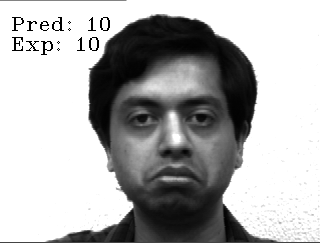

In [ ]:
cv2.putText(image_np, 'Pred: ' + str(prediction[0]), (10, 30), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (0, 255, 0) if prediction[0] == expected_output else (255, 0, 0))
cv2.putText(image_np, 'Exp: ' + str(expected_output), (10, 50), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (0, 255, 0))
cv2_imshow(image_np)

### Evaluating the face classifier

In [ ]:
paths = [os.path.join('/content/yalefaces/test', f) for f in os.listdir('/content/yalefaces/test')]
predictions = []
expected_outputs = []
for path in paths:
  image = Image.open(path).convert('L')
  image_np = np.array(image, 'uint8')
  prediction = lbph_face_classifier.predict(image_np)
  expected_output = int(os.path.split(path)[1].split('.')[0].replace('subject', ''))
  predictions.append(prediction[0])
  expected_outputs.append(expected_output)

In [ ]:
predictions = np.array(predictions)
expected_outputs = np.array(expected_outputs)

In [ ]:
from sklearn.metrics import accuracy_score

accuracy_score(expected_outputs, predictions)

0.7

<Axes: >

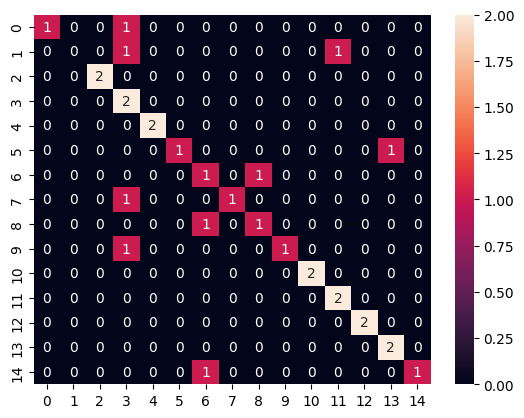

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(expected_outputs, predictions)
sns.heatmap(cm, annot = True)

## Dlib

In [ ]:
from google.colab import files
files.upload()

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
import dlib
import cv2
from google.colab.patches import cv2_imshow

In [12]:
### Detecting facial points
face_detector = dlib.get_frontal_face_detector()
points_detector = dlib.shape_predictor('/content/drive/MyDrive/Colab Files/shape_predictor_68_face_landmarks.dat')

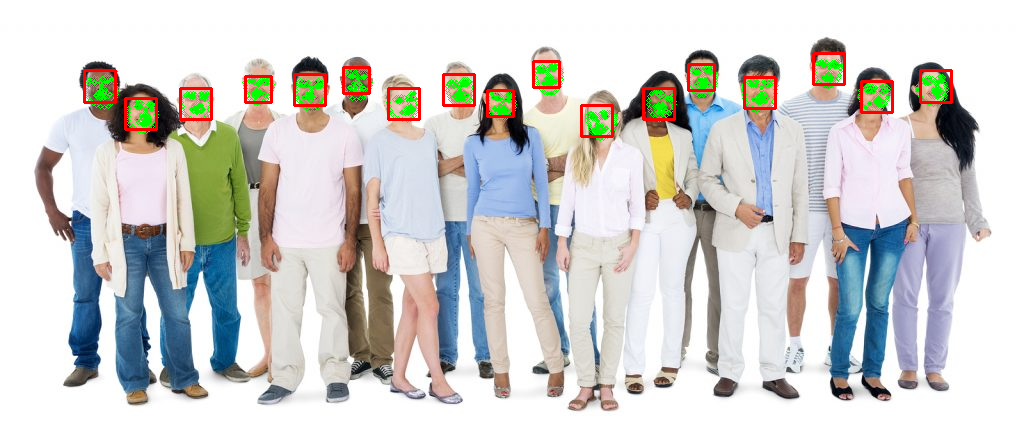

In [13]:
image = cv2.imread('/content/bigstock-Group-of-diverse-people-215128027-1024x443.jpg')
face_detections = face_detector(image, 2)
for face in face_detections:
  points = points_detector(image, face)
  for point in points.parts():
    cv2.circle(image, (point.x, point.y), 2, (0, 255, 0), 1)
  l, t, b, r = face.left(), face.top(), face.bottom(), face.right()
  cv2.rectangle(image, (l, t), (r, b), (0, 0, 255), 2)

cv2_imshow(image)

### Facial descriptors

In [14]:
import os

In [15]:
face_detector = dlib.get_frontal_face_detector()
points_detector = dlib.shape_predictor('/content/drive/MyDrive/Colab Files/shape_predictor_68_face_landmarks.dat')
face_descriptor = dlib.face_recognition_model_v1('/content/drive/MyDrive/Colab Files/dlib_face_recognition_resnet_model_v1.dat')

In [16]:
from PIL import Image
import numpy as np

index = {}
idx = 0
face_descriptors = None

paths = [os.path.join('/content/yalefaces/train', f) for f in os.listdir('/content/yalefaces/train')]
for path in paths:
  image = Image.open(path).convert('RGB')
  image_np = np.array(image, 'uint8')
  face_detection = face_detector(image_np, 4)
  for face in face_detection:
    l, t, r, b = face.left(), face.top(), face.right(), face.bottom()
    cv2.rectangle(image_np, (l, t), (r, b), (0, 255, 0), 2)

    points = points_detector(image_np, face)
    for point in points.parts():
      cv2.circle(image_np, (point.x, point.y), 2, (0, 255, 0), 1)

    facedescriptor = face_descriptor.compute_face_descriptor(image_np, points)
    facedescriptor = [f for f in facedescriptor]
    facedescriptor = np.asarray(facedescriptor, dtype = np.float64)
    facedescriptor = facedescriptor[np.newaxis, :]

    if face_descriptors is None:
      face_descriptors = facedescriptor
    else:
      face_descriptors = np.concatenate((face_descriptors, facedescriptor), axis = 0)

    index[idx] = path
    idx += 1

  #cv2_imshow(image_np)

### Calculating the distance between faces

In [21]:
len(index)

135

In [46]:
# Comparing values at the 0th and 1st index
fir = 0
sec = 1
print(f"The difference of {str(index[fir]).split('/')[4]} and {str(index[sec]).split('/')[4]}")
np.linalg.norm(np.square(face_descriptors[fir]) - np.square(face_descriptors[sec]))

The difference of subject01.normal.gif and subject07.normal.gif


0.18633873087234942

In [47]:
# Finding the linalg.norm for all the values in the index
np.linalg.norm(face_descriptors[0] - face_descriptors, axis = 1)

array([0.        , 0.82662603, 0.65414694, 0.7532907 , 0.63410624,
       0.77676299, 0.89131135, 0.69525734, 0.35502725, 0.84415856,
       0.73580231, 0.81752434, 0.67855487, 0.81138836, 0.76848404,
       0.61350298, 0.75521379, 0.75092177, 0.78160513, 0.85782395,
       0.82662603, 0.76615864, 0.79289498, 0.73533404, 0.51110916,
       0.36759178, 0.73231882, 0.74266087, 0.74169749, 0.70303855,
       0.76202339, 0.82054401, 0.73532665, 0.84041522, 0.82604589,
       0.80590891, 0.75405615, 0.80003241, 0.87740197, 0.84903608,
       0.82894496, 0.89053752, 0.71386736, 0.79237261, 0.84999776,
       0.68513283, 0.67568211, 0.84284894, 0.8422473 , 0.82807796,
       0.78498878, 0.8468303 , 0.7860712 , 0.38352659, 0.7370272 ,
       0.67855487, 0.76727612, 0.66491543, 0.76195602, 0.67330417,
       0.58755691, 0.63847257, 0.72023784, 0.84124064, 0.75249683,
       0.6613299 , 0.7204086 , 0.73911622, 0.67286553, 0.84329173,
       0.79054019, 0.76123512, 0.73982282, 0.72761044, 0.71319

### Detecting the faces with Dlib

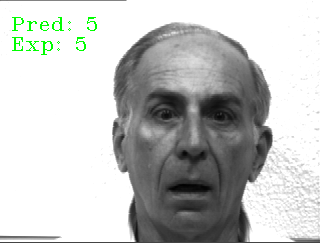

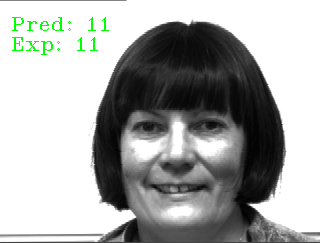

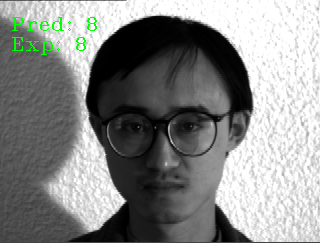

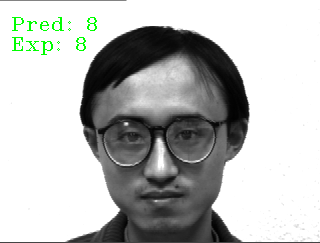

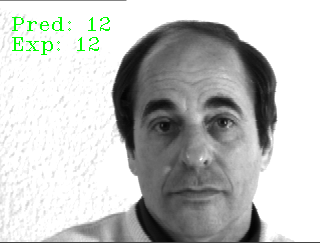

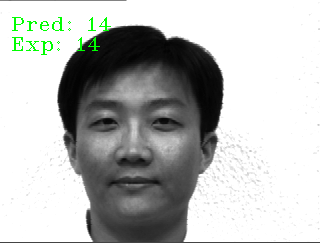

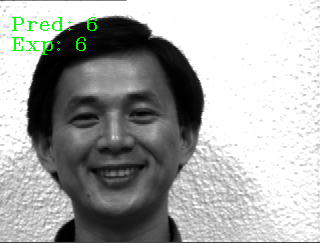

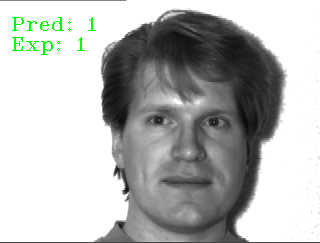

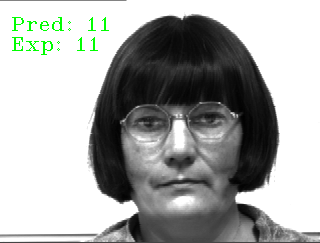

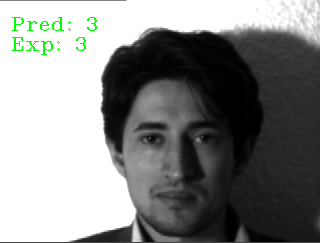

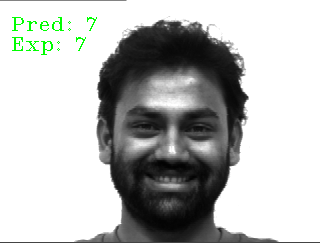

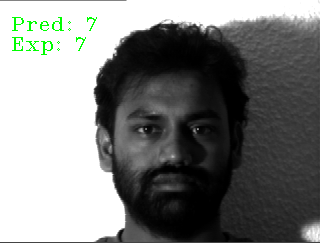

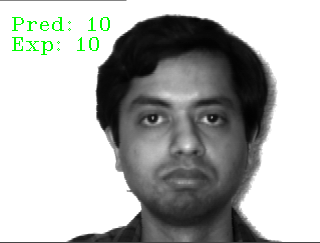

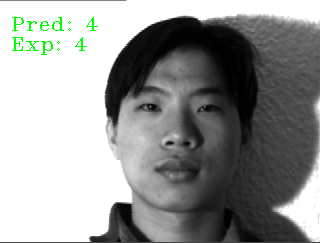

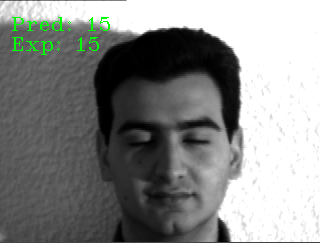

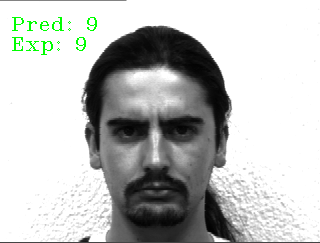

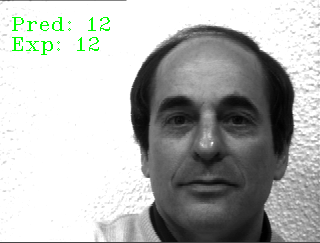

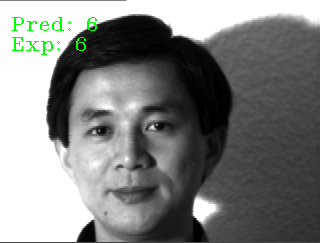

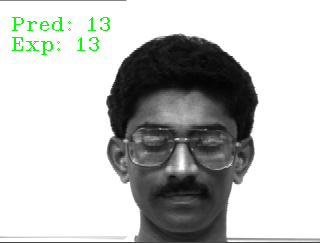

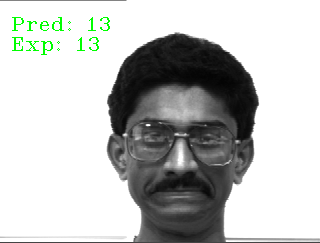

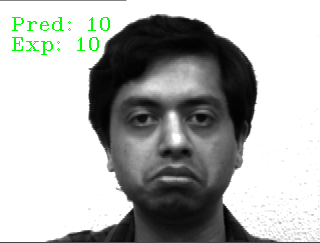

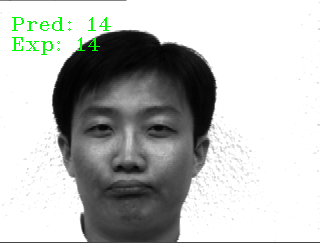

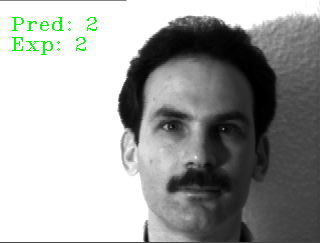

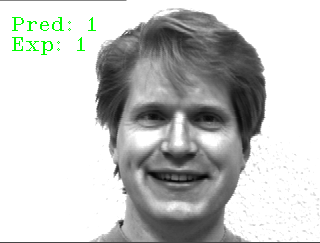

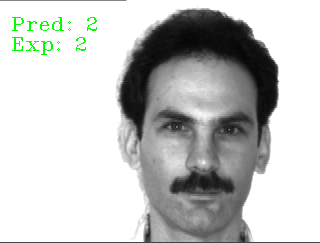

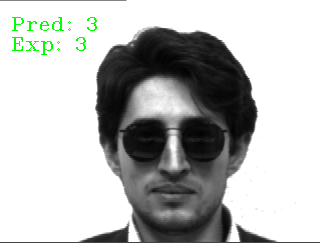

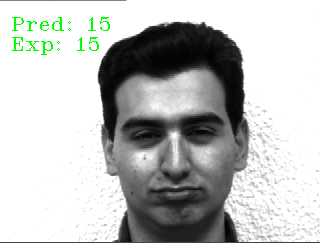

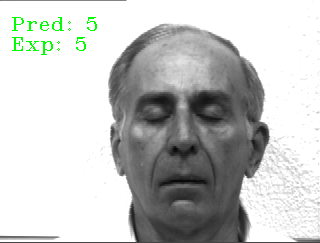

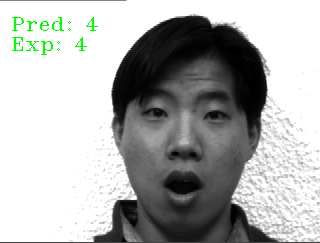

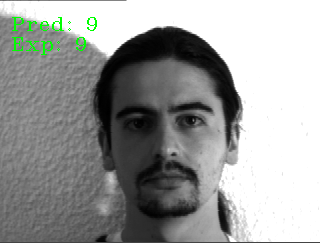

In [65]:
threshold = 0.5
predictions = []
expected_output = []

paths = [os.path.join('/content/yalefaces/test', f) for f in os.listdir('/content/yalefaces/test')]
for path in paths:
  image = Image.open(path).convert('RGB')
  image_np = np.array(image, 'uint8')
  face_detection = face_detector(image_np, 1)
  for face in face_detection:
    points = points_detector(image_np, face)
    facedescriptor = face_descriptor.compute_face_descriptor(image_np, points)
    facedescriptor = [f for f in facedescriptor]
    facedescriptor = np.asarray(facedescriptor, dtype = np.float64)
    facedescriptor = facedescriptor[np.newaxis, :]

    distances = np.linalg.norm(facedescriptor - face_descriptors, axis = 1)
    min_index = np.argmin(distances)
    min_distance = distances[min_index]
    if min_distance <= threshold:
      name_pred = int(os.path.split(index[min_index])[1].split('.')[0].replace('subject', ''))
    else:
      name_pred = 'Not Identified'

    name_real = int(os.path.split(path)[1].split('.')[0].replace('subject', ''))

    predictions.append(name_pred)
    expected_output.append(name_real)

    cv2.putText(image_np, 'Pred: ' + str(name_pred), (10, 30), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (0, 255, 0))
    cv2.putText(image_np, 'Exp: ' + str(name_real), (10, 50), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (0, 255, 0))

  cv2_imshow(image_np)

In [66]:
predictions

[5,
 11,
 8,
 8,
 12,
 14,
 6,
 1,
 11,
 3,
 7,
 7,
 10,
 4,
 15,
 9,
 12,
 6,
 13,
 13,
 10,
 14,
 2,
 1,
 2,
 3,
 15,
 5,
 4,
 9]

In [67]:
expected_output

[5,
 11,
 8,
 8,
 12,
 14,
 6,
 1,
 11,
 3,
 7,
 7,
 10,
 4,
 15,
 9,
 12,
 6,
 13,
 13,
 10,
 14,
 2,
 1,
 2,
 3,
 15,
 5,
 4,
 9]

In [69]:
from sklearn.metrics import accuracy_score

accuracy_score(expected_output, predictions)

1.0

<Axes: >

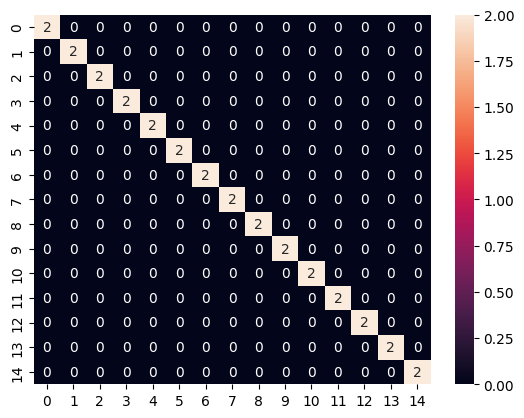

In [71]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(expected_output, predictions)
sns.heatmap(cm, annot = True)